In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import ruptures as rpt

In [2]:
ecg_dataset = pd.read_csv('ecg.csv', header=None)
microsoft_stocks_dataset = pd.read_csv('Microsoft_Stock.csv')
month_value_dataset = pd.read_csv('Month_Value_1.csv')
yahoo_stocks_dataset = pd.read_csv('yahoo_stock.csv')

ecg_columns = [f'ECG_{i+1}' for i in range(140)]
ecg_dataset.columns = ecg_columns + ['label']

yahoo_stocks_dataset['Date'] = pd.to_datetime(yahoo_stocks_dataset['Date'])

In [3]:
month_value_dataset.columns

Index(['Period', 'Revenue', 'Sales_quantity', 'Average_cost',
       'The_average_annual_payroll_of_the_region'],
      dtype='object')

<Axes: >

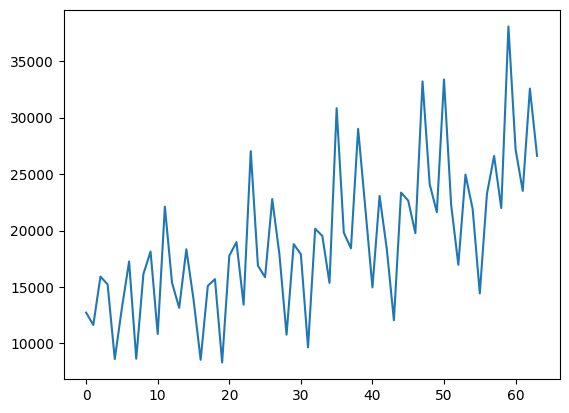

In [4]:
month_value_dataset['Sales_quantity'].plot()

In [5]:
microsoft_stocks_dataset.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

<Axes: >

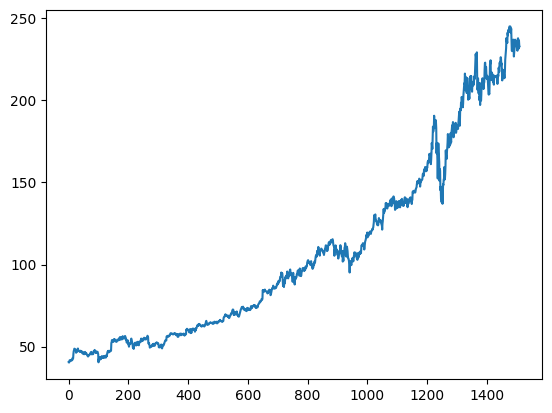

In [6]:
microsoft_stocks_dataset['Open'].plot()

<Axes: >

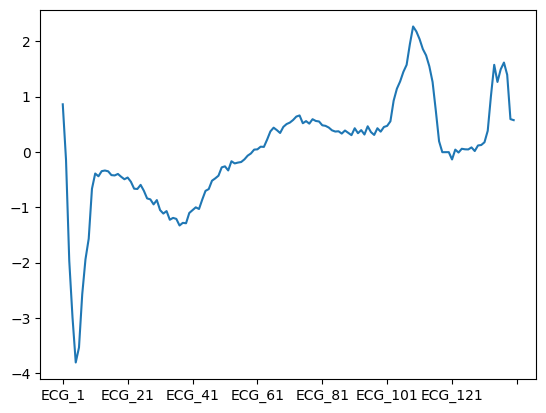

In [7]:
ecg_dataset.loc[40, ecg_columns].plot()

In [8]:
yahoo_stocks_dataset.columns

Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

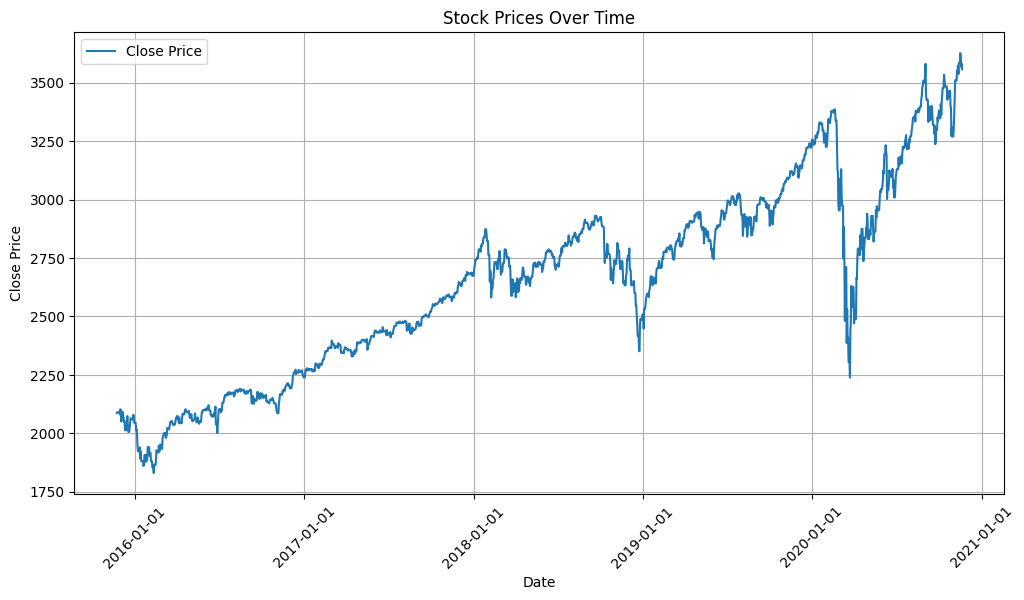

In [9]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(yahoo_stocks_dataset['Date'], yahoo_stocks_dataset['Close'], label="Close Price")

# Format the x-axis to show some dates
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically chooses a good interval
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as YYYY-MM-DD

# Rotate dates for better visibility
plt.xticks(rotation=45)

# Labels and title
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Prices Over Time')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [21]:
from claspy.segmentation import BinaryClaSPSegmentation
from claspy.data_loader import load_tssb_dataset
from time_series_segmentation_benchmark.tssb.utils import load_time_series_segmentation_datasets
from time_series_segmentation_benchmark.tssb.evaluation import covering

In [11]:
dataset, window_size, true_cps, time_series = load_tssb_dataset(names=("CricketX",)).iloc[0,:]
clasp = BinaryClaSPSegmentation()
clasp.fit_predict(time_series)

array([ 712, 1281, 1933, 2581])

array([<Axes: title={'center': 'Segmentation of different umpire cricket signals'}, ylabel='ACC'>,
       <Axes: xlabel='split point', ylabel='ClaSP Score'>], dtype=object)

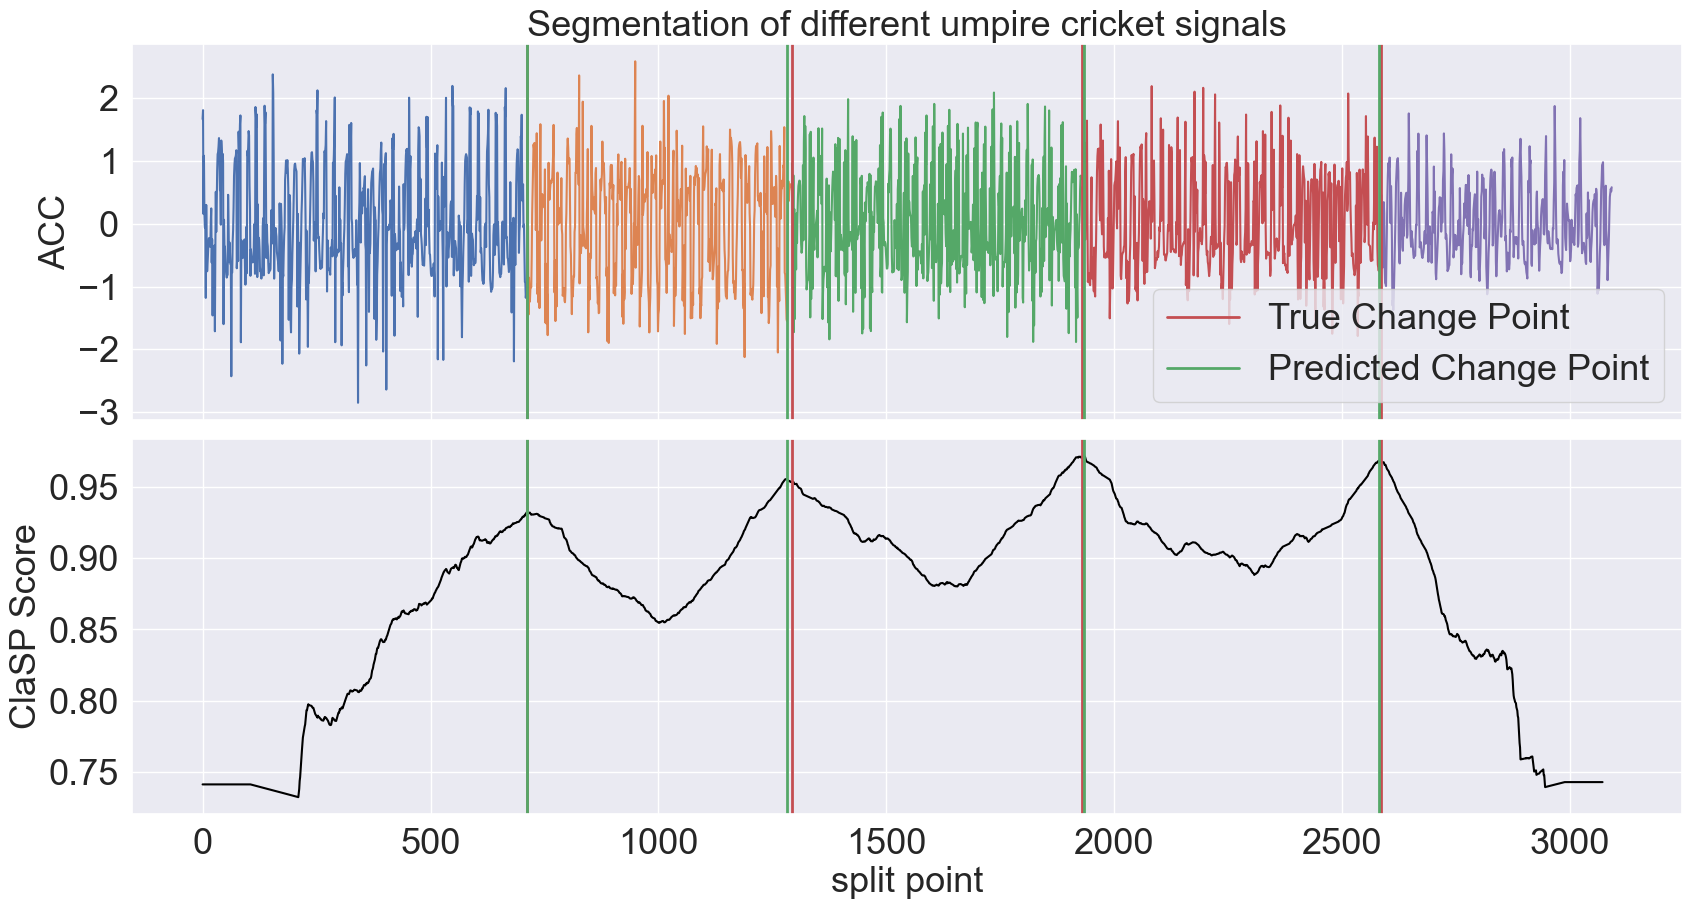

In [12]:
clasp.plot(gt_cps=true_cps, heading="Segmentation of different umpire cricket signals", ts_name="ACC", file_path="segmentation_example.png")

In [22]:
tssb = load_time_series_segmentation_datasets()

In [26]:
for _, (ts_name, window_size, cps, ts) in tssb.iterrows():
   found_cps = rpt.Pelt(model="l2").fit(ts).predict(pen=window_size)
   score = covering({0: cps}, found_cps, ts.shape[0])
   print(f"Time Series: {ts_name}: True Change Points: {cps}, Found Change Points: {found_cps}, Score: {score}")


Time Series: Adiac: True Change Points: [ 572 1012 1232], Found Change Points: [1408], Score: 0.302734375
Time Series: ArrowHead: True Change Points: [753], Found Change Points: [5, 20, 45, 55, 70, 80, 105, 120, 130, 170, 180, 195, 245, 255, 310, 320, 370, 380, 435, 445, 460, 480, 495, 505, 560, 570, 590, 605, 620, 635, 645, 670, 685, 695, 750, 760, 775, 795, 810, 820, 840, 855, 870, 885, 900, 915, 935, 945, 965, 980, 1000, 1010, 1025, 1045, 1060, 1070, 1090, 1105, 1125, 1135, 1155, 1170, 1185, 1200, 1215, 1230, 1250, 1260, 1280, 1295, 1310, 1325, 1340, 1360, 1375, 1385, 1405, 1420, 1435, 1450, 1465, 1485, 1500, 1506], Score: 0.049800796812749
Time Series: Beef: True Change Points: [705], Found Change Points: [1410], Score: 0.5
Time Series: BeetleFly: True Change Points: [1280], Found Change Points: [25, 60, 80, 265, 295, 325, 355, 390, 400, 410, 430, 440, 450, 565, 575, 700, 710, 755, 765, 775, 790, 815, 825, 870, 910, 920, 940, 950, 975, 1030, 1050, 1060, 1085, 1120, 1145, 1180, 1215

# Change point detection

In [13]:
ecg_data = ecg_dataset[ecg_columns].values

In [14]:
# Select first ECG signal (Row 0)
which_row = 30
ecg_signal = ecg_data[which_row]  # Change index to analyze another row

# Apply change point detection (Pelt Algorithm with L2 cost)
algo = rpt.Pelt(model="l2").fit(ecg_signal.reshape(-1, 1))
change_points = algo.predict(pen=10)  # Adjust 'pen' for more/less segmentation

# Print detected change points
print("Change Points Detected:", change_points)


Change Points Detected: [60, 95, 125, 130, 140]


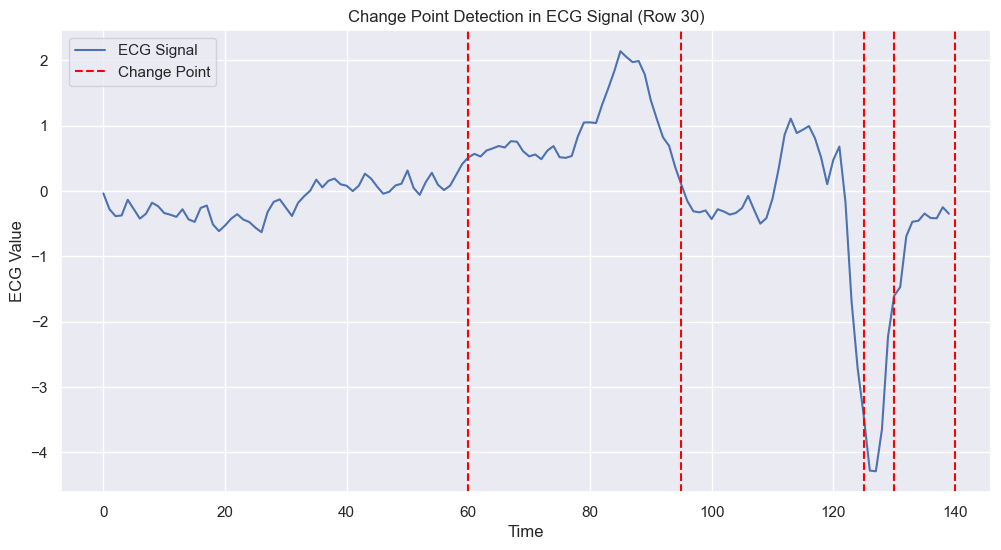

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(ecg_signal, label="ECG Signal")

# Mark detected change points
for cp in change_points:
    plt.axvline(x=cp, color='red', linestyle='--', label="Change Point" if cp == change_points[0] else "")

plt.legend()
plt.title("Change Point Detection in ECG Signal (Row " + str(which_row) + ")")
plt.xlabel("Time")
plt.ylabel("ECG Value")
plt.show()


# KMeans

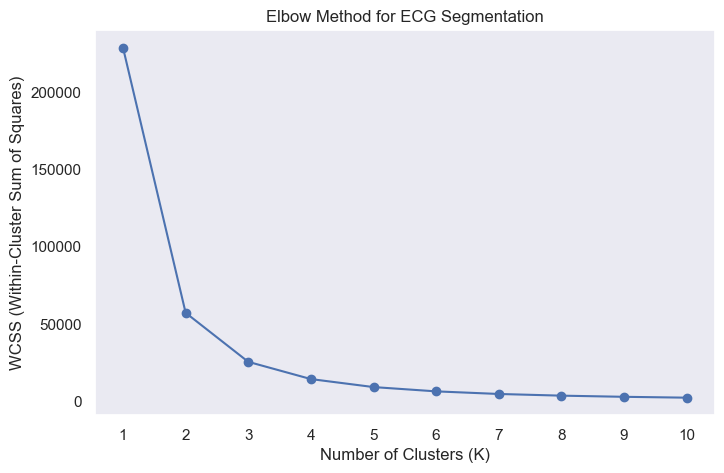

In [16]:
from sklearn.cluster import KMeans

which_row = 0

# Select one ECG signal (first row, ignoring label)
ecg_signal = ecg_dataset.iloc[which_row, :-1].values  # Assuming last column is "label"

# Create features: (time index, ECG value)
time_steps = np.arange(len(ecg_signal)).reshape(-1, 1)
X = np.column_stack((time_steps, ecg_signal))  # Combine time & ECG values

# Apply Elbow Method to find the best K
wcss = []
K_values = range(1, 11)  # Test K from 1 to 10

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K_values, wcss, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for ECG Segmentation")
plt.xticks(K_values)
plt.grid()
plt.show()

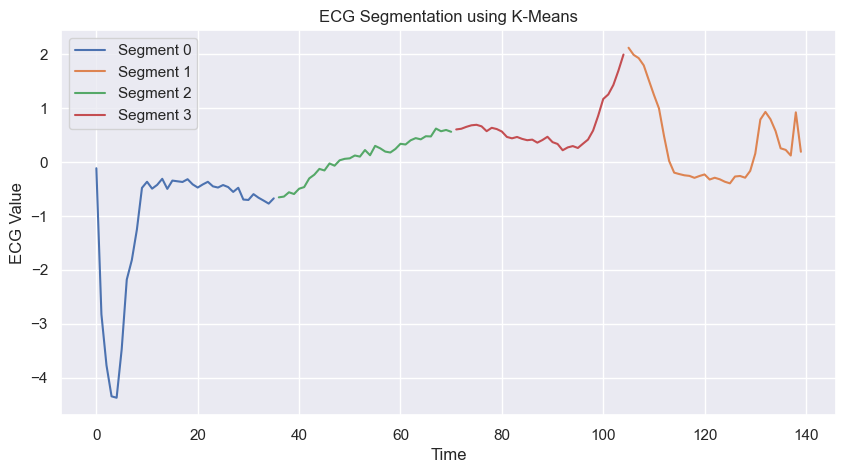

In [17]:
# Apply K-Means with the best K (replace with your best K value)
best_K = 4  # Example value, replace with the best K found from elbow method
kmeans = KMeans(n_clusters=best_K, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

# Plot the segmented ECG signal
plt.figure(figsize=(10, 5))
for cluster in np.unique(labels):
    plt.plot(time_steps[labels == cluster], ecg_signal[labels == cluster], label=f'Segment {cluster}')

plt.xlabel("Time")
plt.ylabel("ECG Value")
plt.title("ECG Segmentation using K-Means")
plt.legend()
plt.show()


# Time series KMeans

In [18]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


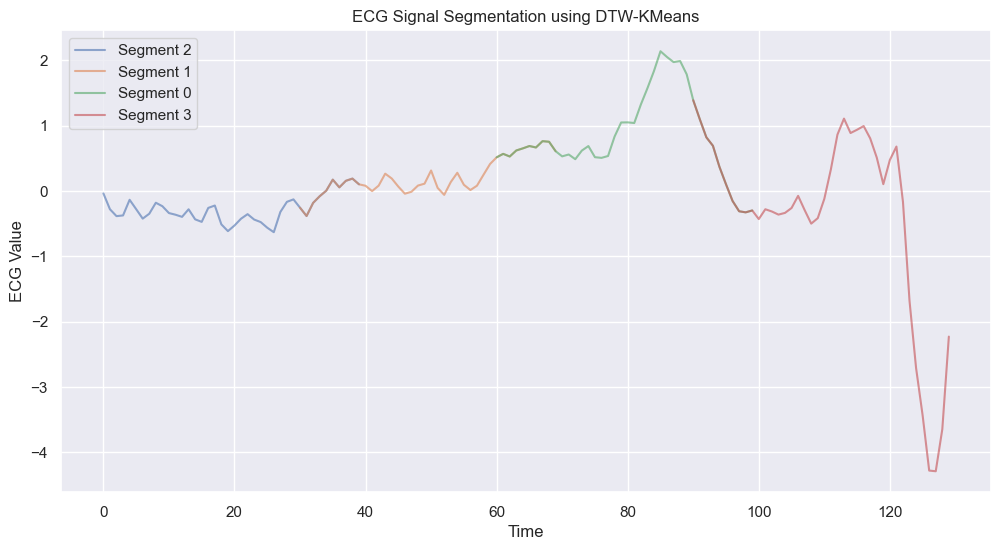

In [19]:
# Select a single ECG signal (e.g., first row)
ecg_signal = ecg_dataset.iloc[30, :-1].values  # Assuming last column is "label"

# Define segmentation parameters
window_size = 40  # Number of points per segment
stride = 30  # Step size for segment extraction

# Create overlapping segments
segments = [ecg_signal[i:i+window_size] for i in range(0, len(ecg_signal)-window_size, stride)]
segments = np.array(segments)

# Normalize segments
segments_scaled = TimeSeriesScalerMeanVariance().fit_transform(segments)

# Apply DTW-KMeans
n_clusters = 4  # Adjust based on elbow method
dtw_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42)
labels = dtw_kmeans.fit_predict(segments_scaled)

# Plot segmented ECG signal
plt.figure(figsize=(12, 6))
time_axis = np.arange(len(ecg_signal))

for i, segment_start in enumerate(range(0, len(ecg_signal)-window_size, stride)):
    plt.plot(time_axis[segment_start:segment_start+window_size], ecg_signal[segment_start:segment_start+window_size], 
             label=f"Segment {labels[i]}", alpha=0.6)

plt.xlabel("Time")
plt.ylabel("ECG Value")
plt.title("ECG Signal Segmentation using DTW-KMeans")
plt.legend()
plt.show()

# BinarySegmentation

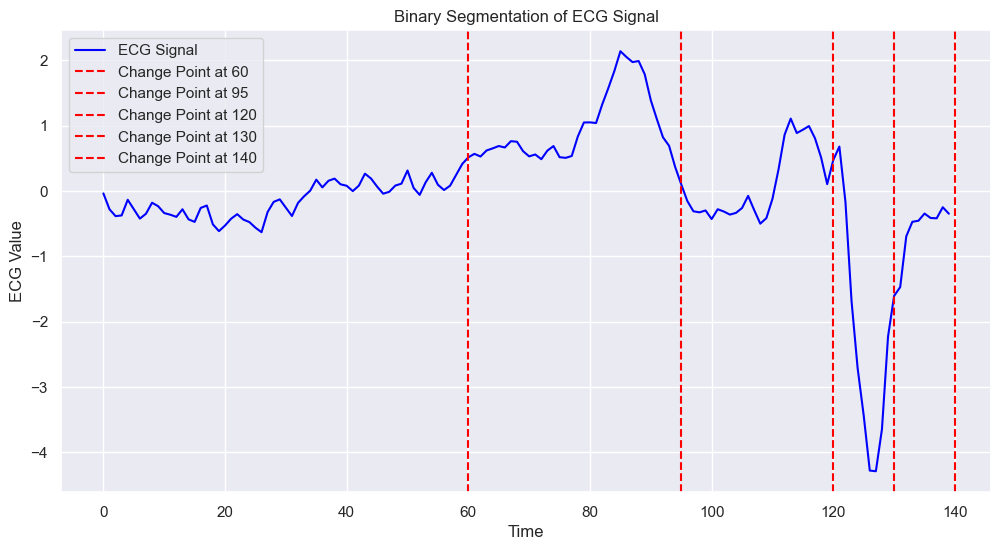

In [20]:
which_row = 30

# Select a single ECG signal (e.g., first row)
ecg_signal = ecg_dataset.iloc[which_row, :-1].values  # Assuming last column is "label"

# Define parameters for the binary segmentation
model = "l2"  # Model used for change point detection (l2: least squares)
algo = rpt.Binseg(model=model).fit(ecg_signal)  # Binary segmentation algorithm

# Detect change points
break_points = 4  # Number of change points to detect
change_points = algo.predict(n_bkps=break_points)  # Set n_bkps=1 for one change point

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(ecg_signal, label="ECG Signal", color="blue")
for cp in change_points:
    plt.axvline(x=cp, color="red", linestyle="--", label=f"Change Point at {cp}")
plt.title("Binary Segmentation of ECG Signal")
plt.xlabel("Time")
plt.ylabel("ECG Value")
plt.legend()
plt.show()